In [1]:
%load_ext autoreload
%autoreload 2



In [4]:
%reload_ext autoreload
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from setdir import *
from plotglider import *
from scipy.io import loadmat # to load bathymetry
import xarray as xr
import seaborn as sns
from scipy import stats

In [5]:
# Need to update this for reading from a netcdf file
yyyymmdd = '20220118'

# Load both glider datasets
file1 = 'unit_409_'+yyyymmdd+'_edit.nc'
infile = cat_interim_path(file1)
unit409 = xr.open_dataset(infile)

file1 = 'unit_398_'+yyyymmdd+'_edit.nc'
infile = cat_interim_path(file1)
unit398 = xr.open_dataset(infile)

# Load glider positions
yyyymmdd = '20220119'

file1 = 'unit_409_position_'+yyyymmdd+'.nc'
infile = cat_interim_path(file1)
unit409pos = xr.open_dataset(infile)

file1 = 'unit_398_position_'+yyyymmdd+'.nc'
infile = cat_interim_path(file1)
unit398pos = xr.open_dataset(infile)

# Location for bathymetry file
matlab_file = 'labsea_66.44W_45.68N_5min.mat'
input_bathy_file = cat_proc_path(matlab_file)
mat_data = loadmat(input_bathy_file)
bathy_data = mat_data['bathy']
bathylat = bathy_data['lat'][0][0].flatten()
bathylon = bathy_data['lon'][0][0].flatten()
bathy = bathy_data['depth'][0][0]



In [ ]:
# Map the bathymetry and glider tracks 
# Ok, the glider tracks are spotty: Might mean that the m_gps_lon and m_gps_lat aren't the right variables to download!
map_tracks(bathylon,bathylat,bathy,unit409,unit398)

In [ ]:
# Map the bathymetry and glider tracks 
# Ok, the glider tracks are spotty: Might mean that the m_gps_lon and m_gps_lat aren't the right variables to download!
map_tracks_pos(bathylon,bathylat,bathy,unit409pos,unit398pos)

In [ ]:
# Plot pressure against time
plot_pressure(unit398,'unit398')
plot_pressure(unit409,'unit409')
# Looks like we are missing recent data from unit398

In [ ]:
# Plot most recent 3 days
plot_tseries(unit398,3,'unit398')
#plot_tseries(unit409,3,'unit409')


In [ ]:
ndays=1
plot_profiles(unit398,ndays,'unit398')
plot_profiles(unit409,ndays,'unit409')


# Load profile indices (dive/climb)

In [6]:
idx_d={} ; idx_c={};
unit398, idx_d['398'], idx_c['398'] = dive_index(unit398) # Start on a dive
unit409, idx_d['409'], idx_c['409'] = dive_index(unit409) # Start on a climb

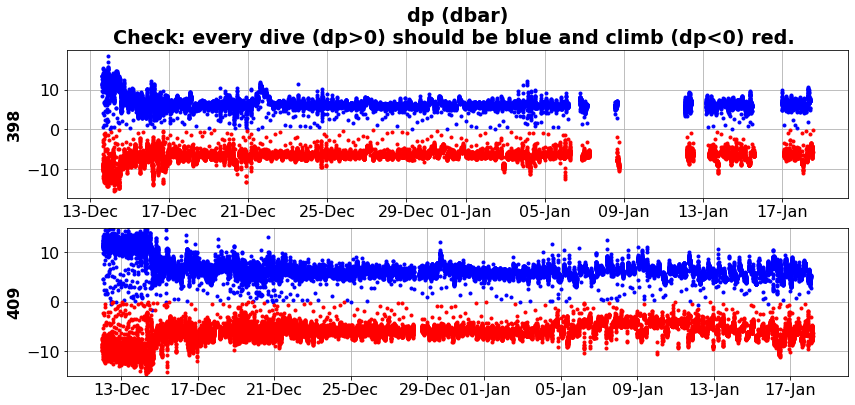

In [7]:
plot_dp(unit398,'398',unit409,'409',idx_d,idx_c)

# Trying to plot color plots of recent data

So idx_d and idx_u are dictionaries, where the keys are the serial number (numeric only) of the gliders, and the values are a numpy array of values [int64].

There is also now a field of the dataset called 'profile_index'.  Dive 1 is called 1.0, and the climb profile associated with the same cycle is called 1.5

Need to check out how it handles yos.  
- Seems fine, but also appears to discard a couple points near surface apogee that could be saved

unit398
* 1. Changing idive, idx was 111 is now  110
* 16. Changing iclimb, idx was 927, is now 928
* 21. Changing idive, idx was 1345 is now  1344
* 105. Changing idive, idx was 26665 is now  26664
* 123. Changing iclimb, idx was 32034, is now 32035

Shifting the dive to start one index sooner, or the climb to end one index later.

unit409

* 7. Changing iclimb, idx was 363, is now 364
* 54. Changing idive, idx was 3277 is now  3276
* 68. Changing iclimb, idx was 5842, is now 5843
* 77. Changing iclimb, idx was 8434, is now 8435
* 222. Changing iclimb, idx was 39853, is now 39854
* 229. Changing iclimb, idx was 42371, is now 42372
* 236. Changing iclimb, idx was 44907, is now 44908
* 240. Changing iclimb, idx was 46218, is now 46219

Shifting the dive to start one index sooner, or the climb to end one index later.



In [11]:
# Need to shift the endpoints of the index slightly, if the dive starts at 
# 5dbar or deeper but could start sooner.
unit_list = ['unit398', 'unit409']
idxname = 'profile_index'
presname = 'pressure_dbar'
for unit in unit_list:
    exec('ds1='+unit)
    pres = ds1[presname].values
    prof_idx = ds1[idxname].values
    dmin = int(prof_idx[np.where(~np.isnan(prof_idx))].min())
    dmax = int(prof_idx[np.where(~np.isnan(prof_idx))].max()-.5)

    print(unit)

    for i in range(dmin,dmax):
        idive = np.where(prof_idx==i)[0]
        iclimb = np.where(prof_idx==i+.5)[0]

        if len(idive):
            pstart = pres[idive[0]]
            if pstart>5:
                val1 = prof_idx[idive[0]-1]
                pstart_1 = pres[idive[0]-1]
                if np.isnan(val1) & (pstart_1<pstart):
                    print(str(i)+'. Changing idive, idx was '+str(idive[0])+' is now ',str(idive[0]-1))
                    prof_idx[idive[0]-1] = i
        if len(iclimb):
            pend = pres[iclimb[-1]]
            pend_1 = pres[iclimb[-1]+1]
            if pend_1 < pend:
                val2 = prof_idx[iclimb[-1]+1]
                if np.isnan(val2):
                    prof_idx[iclimb[-1]+1] = i+.5
                    print(str(i)+'. Changing iclimb, idx was '+str(iclimb[0])+', is now '+str(iclimb[0]+1))

unit398
unit409
77. Changing iclimb, idx was 8434, is now 8435


# Now try some plotting

Using the profile information, plot color plots of data.

(array([ 316.,  333.,  523., 1130., 2644., 4872., 5171., 3472., 2886.,
        1548.,  343.,  105.,   46.,   38.,  175.,  256.,   90.,   68.,
          52.,  100.,  362., 1227., 2825., 5337., 5513., 3299., 1451.,
         776.,  357.,  206.]),
 array([-10.        ,  -9.33333333,  -8.66666667,  -8.        ,
         -7.33333333,  -6.66666667,  -6.        ,  -5.33333333,
         -4.66666667,  -4.        ,  -3.33333333,  -2.66666667,
         -2.        ,  -1.33333333,  -0.66666667,   0.        ,
          0.66666667,   1.33333333,   2.        ,   2.66666667,
          3.33333333,   4.        ,   4.66666667,   5.33333333,
          6.        ,   6.66666667,   7.33333333,   8.        ,
          8.66666667,   9.33333333,  10.        ]),
 <BarContainer object of 30 artists>)

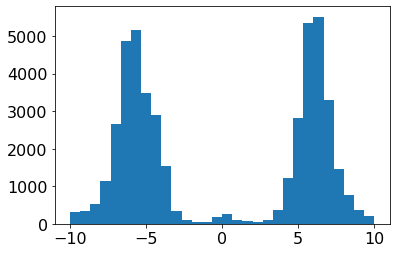

In [12]:
# Trying to decide what size bins to use 
dp = unit409.pressure_dbar.diff(dim='time')
plt.hist(dp, bins=30, range=(-10, 10))
#plt.set_xlabel('diff(pres)')
#plt.set_ylabel('Count')
# Use 10-m bins? with a median for value within the bin?

In [13]:
# Create a regularly gridded product with ~10m depth bins.
# Takes a little while (started 10:47, finished before 10:54)
grid409 = bin_dp(unit409, 'unit409', 10)
grid409.to_netcdf(cat_proc_path(grid409.attrs['unit']+'_bin10m.nc'), mode='w')

grid398 = bin_dp(unit398, 'unit398', 10)
grid398.to_netcdf(cat_proc_path(grid398.attrs['unit']+'_bin10m.nc'), mode='w')



In [ ]:
grid398

# Simple color sections

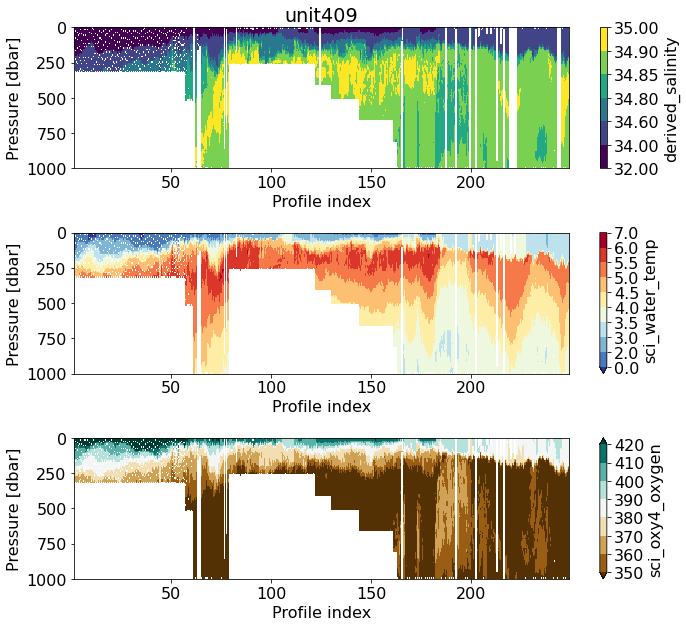

In [15]:
varlist = ['derived_salinity', 'sci_water_temp', 'sci_oxy4_oxygen']
           
plot_sxn(grid409, varlist)


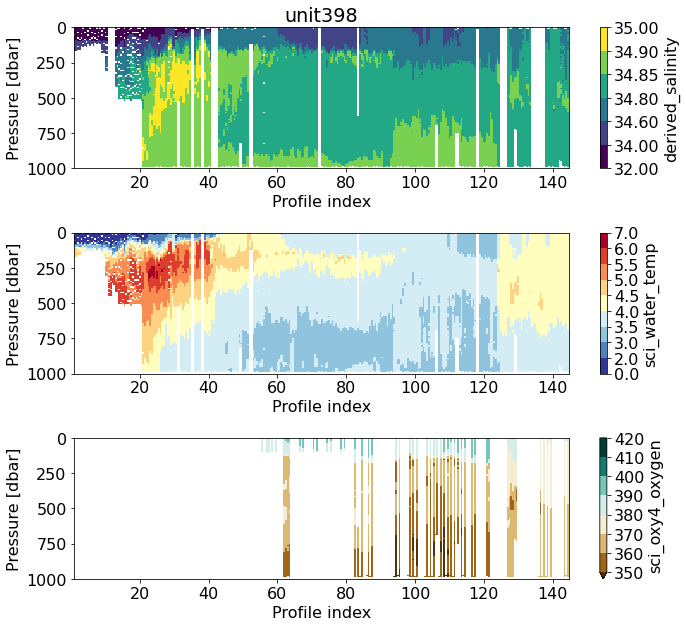

In [16]:
plot_sxn(grid398, varlist)

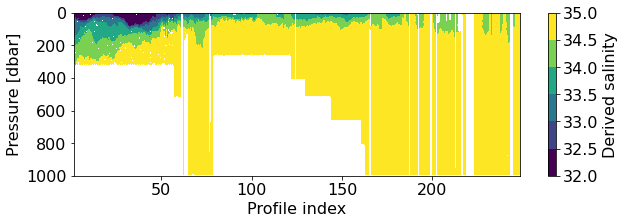

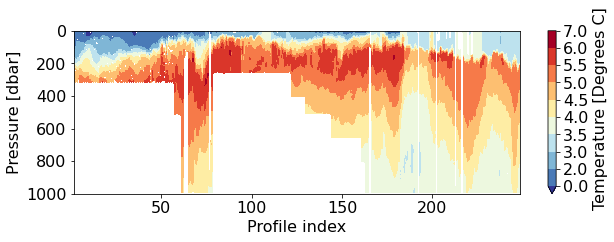

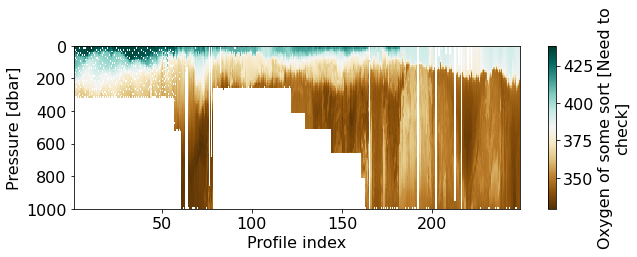

In [77]:
ds1 = grid409

xr.plot.contourf(ds1["salin"],x='divenum',y='pressure', 
                 figsize=(10,3), ylim=[1000,0], yincrease=False,
                add_labels=True)


tlevels = [0, 2, 3, 3.5, 4, 4.5, 5, 5.5, 6, 7]
xr.plot.contourf(ds1["temp"], x='divenum', y='pressure',
                 figsize=(10,3), ylim=[1000,0], yincrease=False,
                 add_labels=True, levels=tlevels, cmap="RdYlBu_r")

xr.plot.pcolormesh(ds1["oxy4"], x='divenum', y='pressure',
                 figsize=(10,3), ylim=[1000,0], yincrease=False,
                 add_labels=True, cmap="BrBG")